In [2]:
from pathlib import Path
import itertools
import json
from typing import Iterable
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
from skimage.metrics import structural_similarity as ssim
import numpy as np

stg_dir = Path("/mnt/NewVolume/aq85800/SpacetimeGaussians/output_sweep_tests")


def gen_color_map(cmap_name):
    i = 0
    cmap = plt.get_cmap(cmap_name)
    while True:
        yield cmap(i)
        i += 1


def recurvive_call(input, depth, callable):
    for d in range(depth):
        input = callable(input)
    return input


def plot_loss_history(fig: Figure, axs: Iterable[Axes], exp_dir: Path):
    ax: Axes = next(axs)
    ax.set_title("Loss coefficients' values by iteration")
    loss_history = pd.read_csv(exp_dir / "loss_history.csv", delimiter=";")
    loss_names = loss_history["loss_name"].unique()
    for loss_name in loss_names:
        named_loss_history = loss_history[loss_history["loss_name"] == loss_name]
        ax.plot(named_loss_history["iteration"],
                named_loss_history["loss"], label=loss_name)
        ax.legend(labels=loss_names, loc="upper right")


def table_metrics(fig: Figure, ax: Iterable[Axes], exp_dir: Path):
    ax: Axes = next(ax)
    ax.set_title("Average Metrics Over Views and Frames")
    ax.axis("off")
    try:
        metrics = recurvive_call(json.load(
            (exp_dir/"30000_runtimeresults.json").open("r")), 2, lambda dic: next(iter(dic.values())))
        ax.table(list(metrics.items()), bbox=(0, 0, 1, 1), colWidths=(.2, 1))
    except FileNotFoundError:
        ax.text(.5, .5, "Experiment failed", ha="center", va="center")
        return


def plot_gt_render_comparison(fig: Figure, axs: Iterable[Axes], exp_dir: Path):
    for imno, imdir in itertools.product(
        [f"{i:>05}.png" for i in ["0", "47"]],
        ["gt", "renders"],
    ):
        ax: Axes = next(axs)
        try:
            ax.set_title(f"{imdir}/{imno}")
            ax.axis("off")
            image = plt.imread(exp_dir / "test"/"ours_30000" / imdir / imno)
            ax.imshow(image)
        except FileNotFoundError:
            ax.text(.5, .5, "Experiment failed", ha="center", va="center")


def imshow_ssim(fig: Figure, axs: Iterable[Axes], exp_dir: Path):
    for imno in [f"{i:>05}.png" for i in ["0", "47"]]:
        ax: Axes = next(axs)
        try:
            gt, render = [plt.imread(exp_dir / "test/ours_30000" / dir / imno)
                          for dir in ["gt", "renders"]]
            ssimv, ssimi = ssim(gt, render, multichannel=True,
                                full=True, channel_axis=-1, data_range=2.)
            ax.set_title(f"{imno} SSIM= {ssimv:.6f}")
            ax.axis("off")
            ax.imshow(ssimi)
        except FileNotFoundError:
            ax.text(.5, .5, "Experiment failed", ha="center", va="center")

                                                                                    PSNR      SSIM     LPIPS  gaussians_count  scale_mean_mean  scale_std_std
dataset_name                                                   reg   regl                                                                                    
cloud+0transp+blackbg+200mocap_bogusorange8000                 4.0   0.000001  30.653833  0.927586  0.075641         209156.0     1.505361e-02       0.155803
                                                                     0.000010  30.587553  0.932893  0.074930         210254.0     1.642603e-02       0.178822
                                                                     0.000100  30.392197  0.933911  0.076827         210595.0     1.346108e-02       0.177744
                                                                     0.001000  30.203714  0.938375  0.078465         213280.0     1.094407e-02       0.161868
                                                    

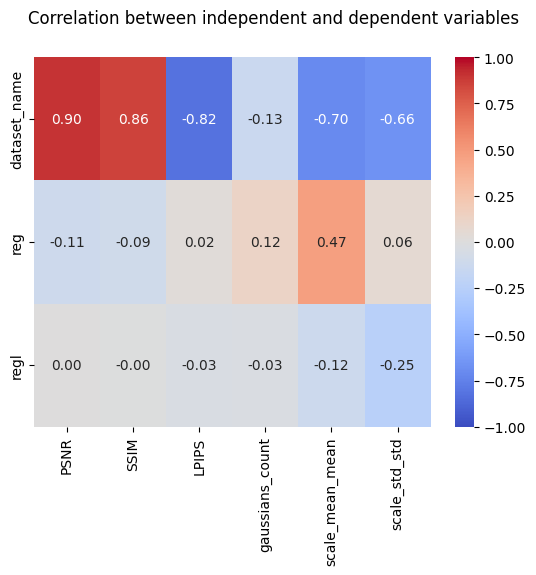

In [ ]:
import glob
import re
import scipy
import seaborn as sb
import pathlib
from dataclasses import dataclass
import plyfile


@dataclass
class SweepExperiment:
    experiment: pathlib.Path
    indep_vars: list[str]
    dep_vars_photometric = ['PSNR', 'SSIM', 'LPIPS']
    dep_vars_gaussian = ['gaussians_count', 'scale_mean_mean', 'scale_std_std']
    dep_vars = dep_vars_photometric + dep_vars_gaussian

    def __init__(self, experiment: pathlib.Path, indep_vars: None | list[str] = None, separator='+'):
        super().__init__()
        self.experiment = experiment
        self.indep_vars = ['dataset_name']
        self.indep_vars += indep_vars or self.experiment.stem.split(separator)
        self.data = pd.DataFrame(columns=self.indep_vars + self.dep_vars)

        for param_dir in itertools.chain.from_iterable(
                Path(datadir).iterdir()
                for datadir in glob.glob(str(self.experiment))):
            try:
                if not param_dir.is_dir():
                    continue
                indep_vars_vals, photometric_dep_vars = \
                    self._read_photometric(param_dir, separator)
                gaussian_dep_vars = self._read_point_cloud(param_dir)

                expvars = {
                    'dataset_name': param_dir.parents[2].stem,
                    **indep_vars_vals,
                    **photometric_dep_vars,
                    **gaussian_dep_vars}
                self.data.loc[len(self.data)] = expvars
            except:
                pass  # Skip directories that do not contain the expected data

    def _read_photometric(self, param_dir: pathlib.Path, separator='+'):
        indep_vars_vals = dict(zip(
            self.indep_vars[1:],
            [float(f)for f in param_dir.name.split(separator)]))
        photometric_dep_vars = next(iter(next(iter(json.load(
            (param_dir / '30000_runtimeresults.json').open()).values())).values()))
        return indep_vars_vals, photometric_dep_vars

    def _read_point_cloud(self, param_dir: pathlib.Path):
        points = plyfile.PlyData.read(
            str(param_dir/"point_cloud/iteration_30000/point_cloud.ply"))
        size_props = pd.DataFrame.from_records(
            points['vertex'][['scale_0', 'scale_1', 'scale_2']])
        scales = np.exp(size_props[['scale_0', 'scale_1', 'scale_2']])

        return dict(zip(self.dep_vars_gaussian, [
            points['vertex'].count,
            scales.mean(0).min(),
            scales.std(0).min(),
        ]))

    def corr(self):
        """Calculate the correlation between the independent and dependent variables.
            Warning: Use only as a rough estimate, as only continuous variables can be correlated with Pearson/Kendall/Spearman method.
        """
        categ = self.data.copy()
        for v in ['dataset_name', 'reg']:
            categ[v] = categ[v].astype('category').cat.codes
        return categ.corr('spearman').loc[self.indep_vars, self.dep_vars]

    # def anova(self) -> tuple[pd.DataFrame, pd.DataFrame]:
    #     """Run an ANOVA test between the independent and dependent variables, returns F-stat and p-value matrices as elements of a tuple."""
    #     f_stat = pd.DataFrame(index=self.indep_vars, columns=self.dep_vars, dtype=float)
    #     p_value = pd.DataFrame(index=self.indep_vars, columns=self.dep_vars, dtype=float)
    #     for i in self.indep_vars:
    #         for d in self.dep_vars:
    #             f_stat.loc[i, d], p_value.loc[i, d] = scipy.stats.f_oneway(
    #                 *[group[d].values for name, group in self.data.groupby(i)]
    #             )
    #     return f_stat, p_value


isotropic_sweep = SweepExperiment(
    pathlib.Path(
        '/mnt/NewVolume/aq85800/SpacetimeGaussians/output_isotropic/*/isotropic/reg+regl')
)
print(isotropic_sweep.data.groupby(isotropic_sweep.indep_vars).mean().to_string())

isotropic_sweep_corr = isotropic_sweep.corr()
fig, ax = plt.subplots(1, 1)
_ = sb.heatmap(isotropic_sweep_corr, annot=True, fmt=".2f",
               cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
_ = fig.suptitle("Correlation between independent and dependent variables")

# for df, stat_name in zip(isotropic_sweep.anova(), ['F-Stat', 'P-Value']):
#     fig, ax = plt.subplots(1, 1)
#     fig.suptitle(f"ANOVA {stat_name} between independent and dependent variables")
#     _ = sb.heatmap(df, annot=True, fmt=".0e", cmap="coolwarm", ax=ax)

Text(0.5, 1.0, 'Corellation of Density Control Parameters to Metrics (50% Worst Experiments)')

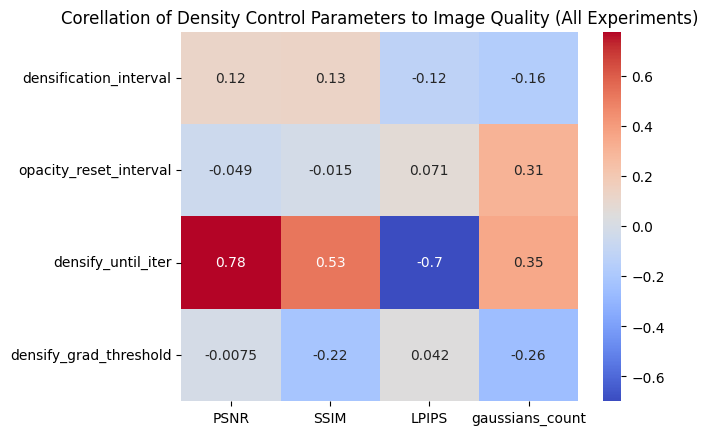

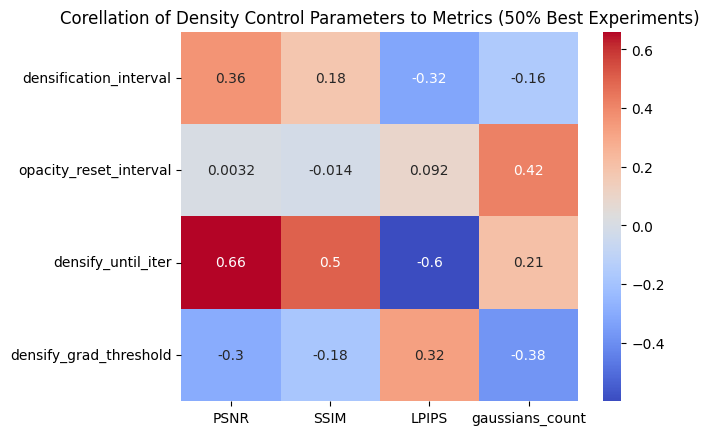

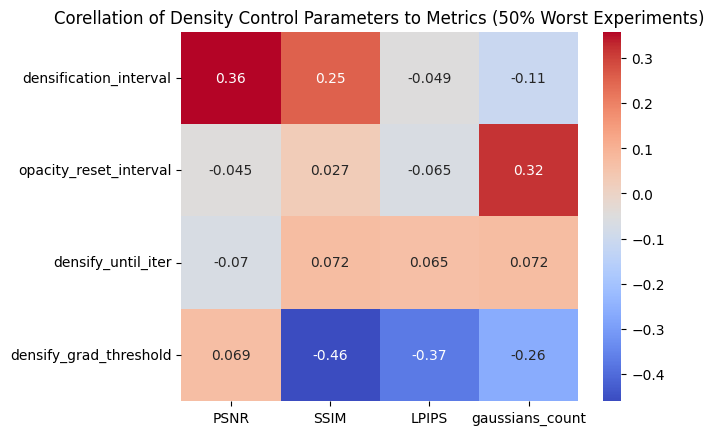

In [ ]:
import pathlib
import re
import seaborn as sb
import plyfile
import pandas as pd
import json
import matplotlib.pyplot as plt

experiment = pathlib.Path(
    '/mnt/NewVolume/aq85800/SpacetimeGaussians/output_sweep_tests/cloud+0transp+blackbg+200mocap_blenderorange_noresize/densification_interval_opacity_reset_interval_densify_until_iter_densify_grad_threshold/')

data = pd.DataFrame(columns=['densification_interval', 'opacity_reset_interval',
                    'densify_until_iter', 'densify_grad_threshold', 'PSNR', 'SSIM', 'LPIPS', 'gaussians_count'])
# iterate over the experiment directory, reading the folder names as the independent variables values, and build a DataFrame
for param_dir in experiment.iterdir():
    if not param_dir.is_dir():
        continue
    indep_vars = dict(zip(data.columns, [float(f)
                      for f in param_dir.name.split('_')]))
    dep_vars = next(iter(next(iter(json.load(
        (param_dir / '30000_runtimeresults.json').open()).values())).values()))
    points = plyfile.PlyData.read(
        str(param_dir/"point_cloud/iteration_30000/point_cloud.ply"))
    expvars = {**indep_vars, **dep_vars,
               'gaussians_count': points.elements[0].count}
    data.loc[len(data)] = expvars


def correlate_dep_vars(data: pd.DataFrame):
    """Calculate the correlation between the independent and dependent variables."""
    return data[data.columns[:4].tolist()+data.columns[4:].tolist()
                ].corr().loc[data.columns[:4].tolist(), data.columns[4:].tolist()]


fig, ax = plt.subplots(1, 1)
sb.heatmap(correlate_dep_vars(data), cmap='coolwarm', annot=True, ax=ax)
ax.set_title(
    'Corellation of Density Control Parameters to Image Quality (All Experiments)')

fig, ax = plt.subplots(1, 1)
best_experiments = data.nlargest(len(data)//2, ['PSNR', 'SSIM'], 'all')
sb.heatmap(correlate_dep_vars(best_experiments),
           cmap='coolwarm', annot=True, ax=ax)
ax.set_title(
    'Corellation of Density Control Parameters to Metrics (50% Best Experiments)')

fig, ax = plt.subplots(1, 1)
worst_experiments = data.nsmallest(len(data)//2, ['PSNR', 'SSIM'], 'all')
sb.heatmap(correlate_dep_vars(worst_experiments),
           cmap='coolwarm', annot=True, ax=ax)
ax.set_title(
    'Corellation of Density Control Parameters to Metrics (50% Worst Experiments)')

In [4]:
# import re

# experiments = [e for e in stg_dir.glob("*") if re.search(r'orange|grey|white|teal|green', str(e)) and not re.search('_noresize', str(e))]
# main_fig = plt.figure(layout="constrained", figsize=(14,len(experiments)*8.5/2))
# figs = main_fig.subfigures(nrows=len(experiments))
# ifigs = figs.flat

# for exp_dir, title_color in zip(experiments, gen_color_map("tab20")):
#     for exp_values_dir in (exp_dir / "reg").glob('0'):
#         fig: Figure = next(ifigs)
#         # if exp_values_dir.name not in ['110']:
#         #     continue
#         axs: np.ndarray[Axes]
#         axs = fig.subplots(2, 4)
#         iaxs = axs.flat
#         fig.suptitle(
#             "/".join(exp_values_dir.parts[-3:]), color=title_color)
#         plot_gt_render_comparison(fig, iaxs, exp_values_dir)
#         plot_loss_history(fig, iaxs, exp_values_dir)
#         table_metrics(fig, iaxs, exp_values_dir)
#         imshow_ssim(fig, iaxs, exp_values_dir)